# <b>Yêu cầu</b>
File <b>Project_2_Sentiment_analysis_Analysis_Evaluate_results.ipynb</b> sẽ thực hiện những yêu cầu sau:

*   Tạo các embeddings sử dụng các bộ biểu diễn văn bản <b>TF-IDF</b>, <b>fastText</b>, và <b>BERT</b>
*   Xây dựng mô hình phân tích ý kiến và đánh giá <b>accuracy</b>, <b>precision</b>, <b>recall</b>, and <b>F1-score</b> cho tổng thể và từng lớp.





# <b>Import</b>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn import svm
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers.experimental.preprocessing import Normalization, Resizing, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

In [ ]:
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <b>Tải dữ liệu</b>

In [ ]:
!gdown https://drive.google.com/drive/folders/1MJ0FaZEr5yhOjJYONbeXSmqeypGxDJob -O /content/data --folder

Retrieving folder list
Processing file 1LrC8hEA6k0ByfJJXdRify6OJ6EMOURt1 sentiment_analysis_data.csv
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1LrC8hEA6k0ByfJJXdRify6OJ6EMOURt1
To: /content/data/sentiment_analysis_data.csv
100% 3.60M/3.60M [00:00<00:00, 325MB/s]
Download completed


In [ ]:
raw_df = pd.read_csv('/content/data/sentiment_analysis_data.csv')
raw_df

,Content,Sentiment
0,news feed annoy respond properly,Negative
1,begin,Neural
2,know include data saver option app worthless n...,Negative
3,still videos load high quality reduce click tw...,Negative
4,kid twice video load anyway,Neural
...,...,...
70425,facebook nothing like use go horrible,Negative
70426,sick update find gotten bad,Negative
70427,miss everything hate suck,Negative
70428,ik stick loading page,Neural


In [ ]:
sentiment_count = raw_df.groupby('Sentiment').count()['Content'].reset_index()
sentiment_count.columns = ['Sentiment', 'Count']
sentiment_count

,Sentiment,Count
0,Negative,19596
1,Neural,27426
2,Positive,23408


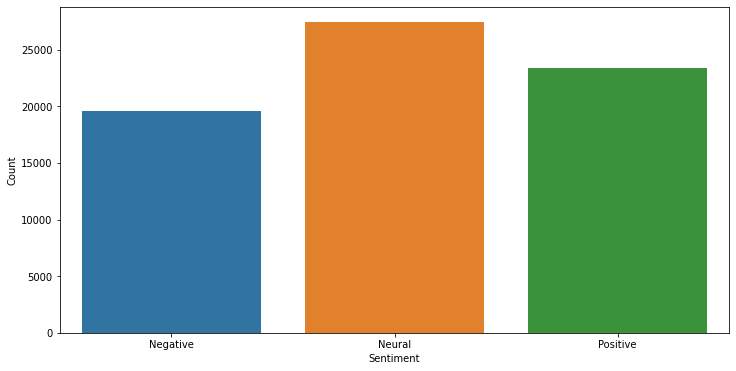

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x= 'Sentiment', y= 'Count', data= sentiment_count)
plt.show()

In [ ]:
n_samples = 6000
positive_sentiment_df = raw_df[raw_df['Sentiment'] == 'Positive'].sample(n= n_samples, random_state= 1)
negative_sentiment_df= raw_df[raw_df['Sentiment'] == 'Negative'].sample(n= n_samples, random_state= 1)
sentiment_df = pd.concat([positive_sentiment_df, negative_sentiment_df], ignore_index=True)
sentiment_df = sentiment_df.sample(frac= 1, random_state= 1).reset_index(drop=True)
sentiment_df

,Content,Sentiment
0,app cut top side use fold,Negative
1,please put back fix big pain butt,Negative
2,facebook need monitor good,Positive
3,base app color far bright,Positive
4,disappoint,Negative
...,...,...
11995,app keep crash let sign ti ame,Negative
11996,video problem,Negative
11997,hey facebook notification freeze since last tu...,Positive
11998,old notification still highlight even though c...,Positive


In [ ]:
sentiment_count = sentiment_df.groupby('Sentiment').count()['Content'].reset_index()
sentiment_count.columns = ['Sentiment', 'Count']
sentiment_count

,Sentiment,Count
0,Negative,6000
1,Positive,6000


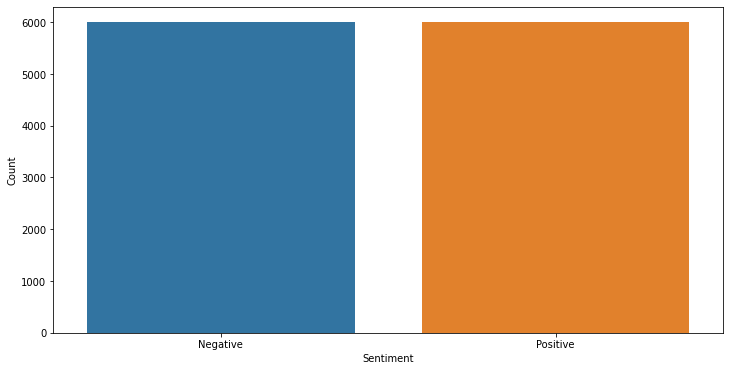

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x= 'Sentiment', y= 'Count', data= sentiment_count)
plt.show()

# <b>Split dataset</b>

In [ ]:
trainset, testset = train_test_split(sentiment_df, test_size= .3, random_state = 42)
trainset.shape
testset.shape

(3600, 2)

# <b>Sentence Embeddings</b>

## <b>TF-IDF</b>

In [ ]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(use_idf=True)
train_vector = vectorizer.fit_transform(trainset.Content)
test_vector = vectorizer.transform(testset.Content)

## <b>fastText</b>

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip
%cd fastText-0.9.2
!make
!pip install .

--2022-11-21 12:43:14--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2 [following]
--2022-11-21 12:43:14--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [  <=>               ]   4.17M  13.9MB/s    in 0.3s    

2022-11-21 12:43:15 (13.9 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
 

In [ ]:
!./download_model.py en

 (100.00%) [==================================================>]


In [ ]:
!ls

alignment		   eval.py		    quantmatrix.o
args.o			   fasttext		    README.md
autotune.o		   fasttext.o		    reduce_model.py
cc.en.300.bin		   fasttext.pc.in	    runtests.py
cc.en.300.bin.gz	   get-wikimedia.sh	    scripts
classification-example.sh  LICENSE		    setup.cfg
classification-results.sh  loss.o		    setup.py
CMakeLists.txt		   Makefile		    src
CODE_OF_CONDUCT.md	   MANIFEST.in		    tests
CONTRIBUTING.md		   matrix.o		    utils.o
crawl			   meter.o		    vector.o
densematrix.o		   model.o		    webassembly
dictionary.o		   productquantizer.o	    website
docs			   python		    wikifil.pl
download_model.py	   quantization-example.sh  word-vector-example.sh


In [ ]:
import fasttext as ft
model=ft.load_model("cc.en.300.bin")

In [ ]:
print(raw_df.Content[0])
model.get_sentence_vector(raw_df.Content[0])

news feed annoy respond properly


array([-3.38318944e-03,  1.18703488e-02,  4.51169275e-02,  5.69568984e-02,
       -1.56236170e-02, -1.48827350e-02, -3.32859345e-02, -2.78635509e-02,
        9.50908230e-04, -3.58513817e-02,  1.63872389e-03,  4.94623370e-02,
        3.10380552e-02,  4.48073782e-02,  3.39685790e-02, -3.14687262e-03,
        7.46637285e-02,  2.05399394e-02, -4.02054749e-02,  4.64017503e-02,
       -9.46509559e-03,  4.00729813e-02, -3.06925122e-02,  2.64896099e-02,
       -4.68817651e-02, -4.72887494e-02,  4.24812594e-03, -3.08279996e-03,
       -5.97244799e-02,  5.83900176e-02,  1.47313867e-02,  1.55698927e-02,
       -1.67772360e-02, -6.45668386e-03,  2.66287159e-02, -1.48538845e-02,
       -3.29914987e-02,  3.42538245e-02, -3.26527208e-02, -2.08345484e-02,
        2.08055843e-02, -2.86870752e-03, -1.78304948e-02,  4.85987999e-02,
       -1.45383840e-02,  2.87844781e-02, -1.34428265e-02,  1.55502902e-02,
        4.19185758e-02,  3.57258879e-02, -5.32684438e-02, -2.63918675e-02,
        7.23578036e-04,  

In [ ]:
ftEmbeddingVectors=[]
for i in range(len(trainset)):
  ftEmbeddingVectors.append(model.get_sentence_vector(trainset.iloc[i,0]))
Test_ftEmbeddingVectors=[]
for i in range(len(testset)):
  Test_ftEmbeddingVectors.append(model.get_sentence_vector(testset.iloc[i,0]))

## BERT

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 5.9 MB/s 
     |████████████████████████████████| 5.5 MB 75.2 MB/s 
     |████████████████████████████████| 1.3 MB 73.0 MB/s 
     |████████████████████████████████| 182 kB 100.5 MB/s 
     |████████████████████████████████| 7.6 MB 60.6 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=e1f5d3d3785dd47fd2a434386f6a511a7c31a75656f5ea217e6bf5a667dc12fd
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
Bert_embeddings_train=[]
Bert_embeddings_test=[]
train_sentences=list(trainset.Content)
test_sentences=list(testset.Content)
model = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')


Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
for i in range(len(train_sentences)):
  vect = model.encode(train_sentences[i])
  Bert_embeddings_train.append(vect)

In [ ]:
for i in range(len(test_sentences)):
  vect = model.encode(test_sentences[i])
  Bert_embeddings_test.append(vect)

# <b>Xây dựng mô hình với SVM</b>

## <b>TF-IDF</b>

In [ ]:
#Học với mô hình SVM
tfidf_SAmodel = svm.SVC()
tfidf_SAmodel.fit(train_vector, trainset.Sentiment)
predict_tfidf=tfidf_SAmodel.predict(test_vector)

In [ ]:
#accuracy
print('accuracy = ',accuracy_score(testset.Sentiment, predict_tfidf))

#Prediction
print('For Negative: precision =', precision_score(testset.Sentiment, predict_tfidf,pos_label="Negative"))
print('For Positive: precision =', precision_score(testset.Sentiment, predict_tfidf,pos_label="Positive"))

#Recall
print('For Negative: recall =', recall_score(testset.Sentiment, predict_tfidf,pos_label="Negative"))
print('For Positive:  recall =', recall_score(testset.Sentiment, predict_tfidf,pos_label="Positive"))

#F1_score
print('For Negative: f1_score =', f1_score(testset.Sentiment, predict_tfidf,pos_label="Negative"))
print('For Positive: f1_score =', f1_score(testset.Sentiment, predict_tfidf,pos_label="Positive"))


accuracy =  0.9213888888888889
For Negative: precision = 0.9345203905801264
For Positive: precision = 0.9090909090909091
For Negative: recall = 0.905902004454343
For Positive:  recall = 0.9368070953436807
For Negative: f1_score = 0.9199886909810574
For Positive: f1_score = 0.9227409227409228


## <b>fastText</b>

In [ ]:
FastTextSAmodel = svm.SVC()
FastTextSAmodel.fit(ftEmbeddingVectors, trainset.Sentiment)
predict_FastText=FastTextSAmodel.predict(Test_ftEmbeddingVectors)

In [ ]:
#accuracy
print('accuracy = ',accuracy_score(testset.Sentiment, predict_FastText))

#Prediction
print('For Negative: precision =', precision_score(testset.Sentiment, predict_FastText,pos_label="Negative"))
print('For Positive: precision =', precision_score(testset.Sentiment, predict_FastText,pos_label="Positive"))

#Recall
print('For Negative: recall =', recall_score(testset.Sentiment, predict_FastText,pos_label="Negative"))
print('For Positive:  recall =', recall_score(testset.Sentiment, predict_FastText,pos_label="Positive"))

#F1_score
print('For Negative: f1_score =', f1_score(testset.Sentiment, predict_FastText,pos_label="Negative"))
print('For Positive: f1_score =', f1_score(testset.Sentiment, predict_FastText,pos_label="Positive"))

accuracy =  0.8866666666666667
For Negative: precision = 0.8938706015891033
For Positive: precision = 0.8797606093579978
For Negative: recall = 0.8769487750556793
For Positive:  recall = 0.8963414634146342
For Negative: f1_score = 0.8853288364249579
For Positive: f1_score = 0.8879736408566722


## <b>BERT</b>

In [ ]:
BERT_SAmodel = svm.SVC()

Bert_embeddings_train_=np.float32(Bert_embeddings_train)
Bert_embeddings_test_=np.float32(Bert_embeddings_test)

BERT_SAmodel.fit(Bert_embeddings_train_, trainset.Sentiment)
predict_Bert=BERT_SAmodel.predict(Bert_embeddings_test_)

In [ ]:
print("Evalute")
#accuracy
print('accuracy = ',accuracy_score(testset.Sentiment, predict_FastText))

#Prediction
print('For Negative: precision =', precision_score(testset.Sentiment, predict_Bert,pos_label="Negative"))
print('For Positive: precision =', precision_score(testset.Sentiment, predict_Bert,pos_label="Positive"))

#Recall
print('For Negative: recall =', recall_score(testset.Sentiment, predict_Bert,pos_label="Negative"))
print('For Positive:  recall =', recall_score(testset.Sentiment, predict_Bert,pos_label="Positive"))

#F1_score
print('For Negative: f1_score =', f1_score(testset.Sentiment, predict_Bert,pos_label="Negative"))
print('For Positive: f1_score =', f1_score(testset.Sentiment, predict_Bert,pos_label="Positive"))

Evalute
accuracy =  0.8866666666666667
For Negative: precision = 0.8522848034006376
For Positive: precision = 0.8882421420256111
For Negative: recall = 0.8930957683741648
For Positive:  recall = 0.8458980044345898
For Negative: f1_score = 0.8722131593257204
For Positive: f1_score = 0.8665530948324817
